In [3]:
import datetime
import pytz

import matplotlib.pyplot as plt
import mplcyberpunk

from pathlib import Path
import pandas as pd
import numpy as np
from astropy.io import fits
import astropy.wcs as fitswcs
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, get_moon, Angle
from astropy.time import Time
from astropy.table import Table
import astroplan
from specutils.spectra.spectrum1d import Spectrum1D
from astropy.visualization import quantity_support
from specutils.manipulation import FluxConservingResampler

_ = quantity_support()
plt.style.use("cyberpunk")

In [6]:
df = pd.read_csv("sky_spectra.csv")
moonfree = df[(df['moon_alt'] < -10) & (df['disperser'] == '270_gpm')]
moonfree

,file,ut,alt,az,moon_alt,moon_az,moon_ill,disperser
1,./2004.0413/skysub_a2034.bg_1_comb.fits,2004-04-13T08:25:25,81.18,75.47,-17.42,107.26,37,270_gpm
3,./2004.0413/skysub_F2.20.bg_1_comb.fits,2004-04-13T05:53:13,56.71,278.43,-47.97,91.12,38,270_gpm
4,./2004.0414/skysub_F2.bg_1_comb.fits,2004-04-14T05:11:49,65.04,274.96,-65.06,67.04,28,270_gpm
5,./2004.0414/skysub_F2.bg_2_comb.fits,2004-04-14T07:00:59,41.07,284.86,-43.32,87.36,27,270_gpm
6,./2004.0415/skysub_F2.bg_3_comb.fits,2004-04-15T05:48:01,55.37,278.13,-64.16,53.43,19,270_gpm
...,...,...,...,...,...,...,...,...
4126,./2020.1013/skysub_m31_pne_20_9_comb.fits,2020-10-13T08:16:47,66.13,300.54,-16.84,60.23,17,270_gpm
4129,./2020.1024/skysub_jiang_c2_1_comb.fits,2020-10-24T12:04:06,65.47,80.09,-59.19,282.18,60,270_gpm
4132,./2020.1024/skysub_Rank13_1_comb.fits,2020-10-24T08:14:37,50.94,204.84,-13.27,252.44,58,270_gpm
4133,./2020.1025/skysub_jiang_c2_1_comb.fits,2020-10-25T11:29:55,59.13,78.40,-41.03,273.43,69,270_gpm


In [7]:
new_disp_grid = np.arange(3850, 6800, 2) * u.AA
fluxcon = FluxConservingResampler()

In [11]:
fluxes = []
for i, r in moonfree.iterrows():
    sp = Spectrum1D.read(r['file'])
    trim_sp = fluxcon(sp, new_disp_grid)
    fluxes.append(trim_sp.flux)

In [12]:
fluxes = np.array(fluxes)

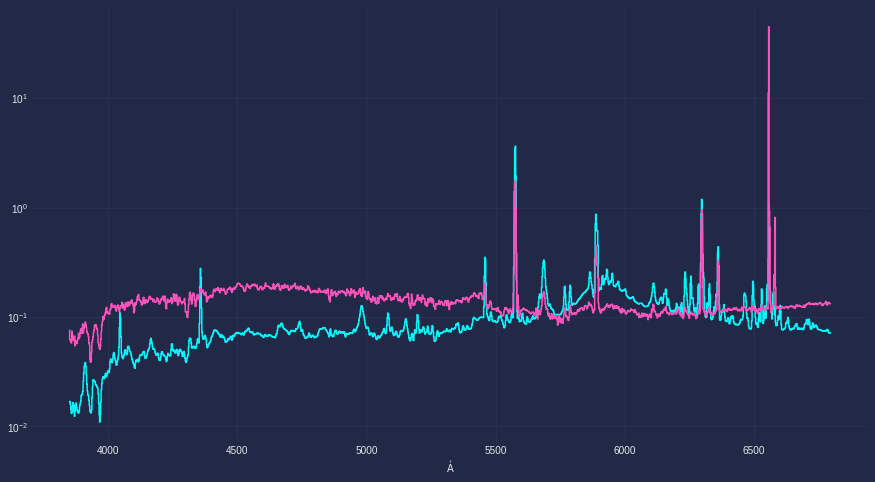

In [23]:
plt.figure(figsize=[15,8])
plt.yscale('log')
plt.step(new_disp_grid, np.mean(fluxes, axis=0))
plt.step(new_disp_grid, np.std(fluxes, axis=0))
plt.show()

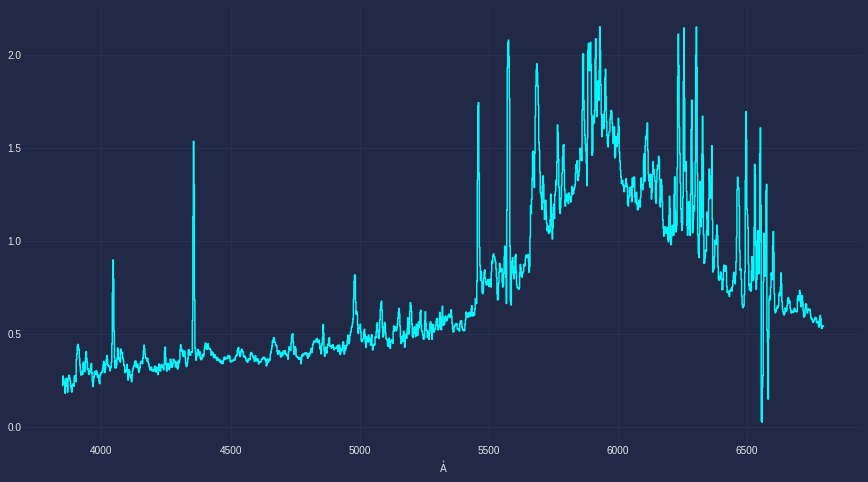

In [35]:
plt.figure(figsize=[15,8])
#plt.yscale('log')
plt.step(new_disp_grid, np.mean(fluxes, axis=0)/np.std(fluxes, axis=0))
plt.show()

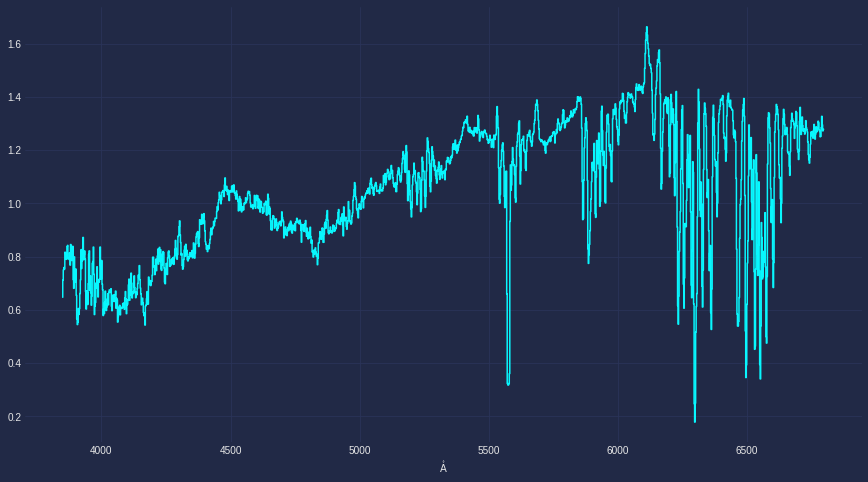

In [34]:
plt.figure(figsize=[15,8])
#plt.yscale('log')
plt.step(new_disp_grid, 2.5 * np.log10(fluxes[-1, :] / fluxes[2200, :]))
plt.show()